# Phase Slope Index

## 1. Convert MNE sample data to BIDS format

(Raw data sets that meet the BIDS format can skip this step)

In [1]:
import json
import os.path as op
import shutil
from pprint import pprint

import mne
from mne.datasets import sample

from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events

In [2]:
# Initialization:

# data_path: Retrieves the path to the sample data directory
# event_id: Defines a dictionary mapping event labels to numeric identifiers.
data_path = sample.data_path()
event_id = {
    "Auditory/Left": 1,
    "Auditory/Right": 2,
    "Visual/Left": 3,
    "Visual/Right": 4,
    "Smiley": 5,
    "Button": 32,
}

fname_raw = data_path / "MEG/sample/sample_audvis_filt-0-40_raw.fif"
fname_event = data_path / "MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
fname_er = op.join(data_path, "MEG", "sample", "ernoise_raw.fif")  # empty room

# Reading Raw Data and Event Information 
raw = mne.io.read_raw(fname_raw)
events = mne.read_events(fname_event)

# Loads the empty room recording to capture sensor noise
raw_er = mne.io.read_raw(fname_er)

# Specify power line frequency as required by BIDS
raw.info["line_freq"] = 60
raw_er.info["line_freq"] = 60


Opening raw data file /home/mne_user/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Opening raw data file /home/mne_user/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.


In [3]:
raw.info

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 line_freq: 60.0
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>

In [4]:
# Defines the directory path where the output BIDS formatted data will be saved.
output_path = op.join(data_path, "..", "MNE-sample-data-bids")

# Checks if the output directory already exists. 
# If it does, it removes the directory to ensure a fresh start.
if op.exists(output_path):
    shutil.rmtree(output_path)

# Specifying the BIDS Path
bids_path = BIDSPath(
    subject="01", 
    session="01", 
    task="example", 
    run="01", 
    datatype="meg", 
    root=output_path,
)

# Writing the Raw Data to BIDS Format
# For EEG and iEEG data, conversion will be to BrainVision format; for MEG, conversion will be to FIFF.
raw = write_raw_bids(
    raw=raw,
    bids_path=bids_path,
    events=events,
    event_id=event_id,
    empty_room=raw_er,
    overwrite=True,
)

# Get the sidecar ``.json`` file
sidecar_json_bids_path = bids_path.copy().update(suffix="meg", extension=".json")
sidecar_json_content = sidecar_json_bids_path.fpath.read_text(encoding="utf-8-sig")
print(sidecar_json_content)


Opening raw data file /home/mne_user/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Opening raw data file /home/mne_user/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Writing '/home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/README'...
Writing '/home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/participants.tsv'...
Writing '/home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/participants.json'...
Writing of electrodes.tsv is not supported for data type "meg". S

In [5]:
# Displaying the Directory Structure
print_dir_tree(output_path)

|MNE-sample-data-bids/
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-01/
|------ ses-01/
|--------- sub-01_ses-01_scans.tsv
|--------- meg/
|------------ sub-01_ses-01_coordsystem.json
|------------ sub-01_ses-01_task-example_run-01_channels.tsv
|------------ sub-01_ses-01_task-example_run-01_events.json
|------------ sub-01_ses-01_task-example_run-01_events.tsv
|------------ sub-01_ses-01_task-example_run-01_meg.fif
|------------ sub-01_ses-01_task-example_run-01_meg.json
|--- sub-emptyroom/
|------ ses-20021206/
|--------- sub-emptyroom_ses-20021206_scans.tsv
|--------- meg/
|------------ sub-emptyroom_ses-20021206_task-noise_channels.tsv
|------------ sub-emptyroom_ses-20021206_task-noise_meg.fif
|------------ sub-emptyroom_ses-20021206_task-noise_meg.json


## 2. Import BIDS dataset

In [6]:
# Note: write_raw_bids() stores only the event labels (keys), and discards the numeric values (values), requiring redefinition here.

raw = read_raw_bids(bids_path=bids_path)
# events, event_id = mne.events_from_annotations(raw)
events, _ = mne.events_from_annotations(raw, event_id=event_id) 

# Selecting a Specific Event Type
# Targets the "Visual/Right" event, which has an ID of 4.
# Epoch Window (second)
event_id, tmin, tmax = 4, -0.2, 0.5

# pick MEG channels
picks = mne.pick_types(
    raw.info, meg=True, eeg=False, stim=False, eog=True, exclude="bads"
)

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6),
)


Opening raw data file /home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/ses-01/meg/sub-01_ses-01_task-example_run-01_meg.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading events from /home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/ses-01/meg/sub-01_ses-01_task-example_run-01_events.tsv.
Reading channel info from /home/mne_user/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/ses-01/meg/sub-01_ses-01_task-example_run-01_channels.tsv.
Used Annotations descriptions: ['Auditory/Left', 'Auditory/Right', 'Button', 'Smiley', 'Visual/Left', 'Visual/Right']
Not setting metadata
70 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dime

In [7]:
epochs.info

<Info | 17 non-empty values
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 203 Gradiometers, 102 Magnetometers, 1 EOG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 line_freq: 60.0
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 306
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on
 sfreq: 150.2 Hz
 subject_info: 3 items (dict)
>

## 3. Compute Phase Slope Index (PSI) in source space for a visual stimulus


In [8]:
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne_connectivity import phase_slope_index, seed_target_indices
import numpy as np

# Source Estimate:
subjects_dir = data_path / "subjects"
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"
fname_label = data_path / "MEG/sample/labels/Vis-lh.label"

method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

inverse_operator = read_inverse_operator(fname_inv)


# Compute inverse solution and for each epoch. Note that since we are passing
# the output to both extract_label_time_course and the phase_slope_index
# functions, we have to use "return_generator=False", since it is only possible
# to iterate over generators once.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr**2
stcs = apply_inverse_epochs(
    epochs, inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
)

# Now, we generate seed time series by averaging the activity in the left
# visual corex
label = mne.read_label(fname_label)
src = inverse_operator["src"]  # the source space used
seed_ts = mne.extract_label_time_course(
    stcs, label, src, mode="mean_flip", verbose="error"
)

# Combine the seed time course with the source estimates. There will be a total
# of 7500 signals:
# index 0: time course extracted from label
# index 1..7499: dSPM source space time courses
stcs = apply_inverse_epochs(
    epochs, inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
)
comb_ts = list(zip(seed_ts, stcs))

# Construct indices to estimate connectivity between the label time course
# and all source space time courses
vertices = [src[i]["vertno"] for i in range(2)]
n_signals_tot = 1 + len(vertices[0]) + len(vertices[1])

indices = seed_target_indices([0], np.arange(1, n_signals_tot))

Reading inverse operator decomposition from /home/mne_user/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing 

In [9]:
# Compute the PSI in the frequency range 10Hz-20Hz. We exclude the baseline
# period from the connectivity estimation.
fmin = 10.0
fmax = 20.0
tmin_con = 0.0
sfreq = epochs.info["sfreq"]  # the sampling frequency

psi = phase_slope_index(
    comb_ts,
    mode="multitaper",
    indices=indices,
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    tmin=tmin_con,
)


Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 7498 connections
    using t=0.000s..0.499s for estimation (76 points)
    frequencies: 11.9Hz..19.8Hz (5 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density

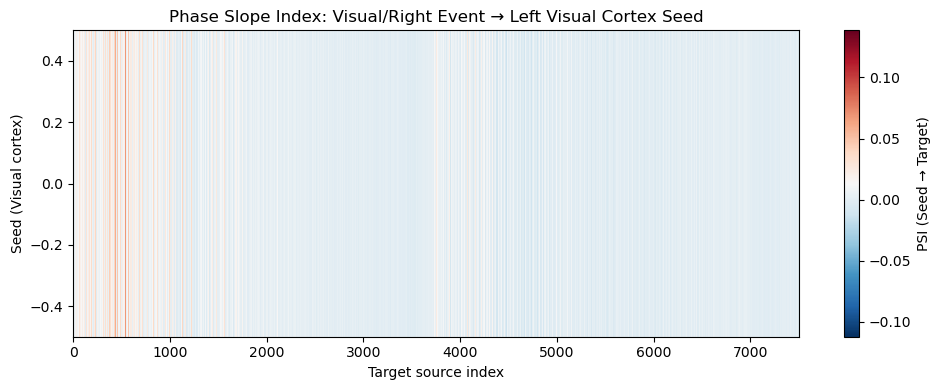

In [10]:
import matplotlib.pyplot as plt

psi_matrix = psi.get_data(output="dense")[:, :, 0]  # shape: [n_signals, n_signals]


plt.figure(figsize=(10, 4))
plt.imshow(psi_matrix[0:1, 1:], aspect="auto", cmap="RdBu_r", origin="lower")
plt.colorbar(label="PSI (Seed → Target)")
plt.xlabel("Target source index")
plt.ylabel("Seed (Visual cortex)")
plt.title("Phase Slope Index: Visual/Right Event → Left Visual Cortex Seed")
plt.tight_layout()
plt.show()


In [11]:
# Generate a SourceEstimate with the PSI. This is simple since we used a single
# seed (inspect the indices variable to see how the PSI scores are arranged in
# the output)
psi_stc = mne.SourceEstimate(
    psi.get_data(), vertices=vertices, tmin=0, tstep=1, subject="sample"
)

# Now we can visualize the PSI using the :meth:`~mne.SourceEstimate.plot`
# method. We use a custom colormap to show signed values
v_max = np.max(np.abs(psi.get_data()))
brain = psi_stc.plot(
    surface="inflated",
    hemi="lh",
    time_label="Phase Slope Index (PSI)",
    subjects_dir=subjects_dir,
    clim=dict(kind="percent", pos_lims=(95, 97.5, 100)),
)
brain.show_view("medial")
brain.add_label(str(fname_label), color="green", alpha=0.7)


Using pyvistaqt 3d backend.
Using control points [0.03622925 0.05660114 0.13862278]


RuntimeError: Cannot connect to a valid display